In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
from torchvision import datasets, transforms
from torchvision.utils import make_grid

#from unet import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
print(device)

from unet.unet import UNetModel

cpu


In [3]:
def init_nn():
    # From https://github.com/openai/guided-diffusion/tree/main/guided_diffusion:
    return UNetModel(
        in_channels=1,
        model_channels=128,
        out_channels=1,
        num_res_blocks=2,
        attention_resolutions=(),
        dropout=0.1,
        channel_mult=(0.5, 1, 1),
        num_heads=4,
        use_scale_shift_norm=True,
        temb_scale=1000,
    )

In [4]:
model = init_nn().to(device)
num_of_parameters = sum(map(torch.numel, model.parameters()))
print(num_of_parameters)

6615361


In [5]:
batch_size = 64
# Define data transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training set
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Download and load the test set
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Example of accessing data
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Shape of images: {images.shape}")
print(f"Example label: {labels[0]}")


Training set size: 60000
Test set size: 10000
Shape of images: torch.Size([64, 1, 28, 28])
Example label: 3


In [6]:
for x,y in train_loader:
    print(x.shape)
    break

torch.Size([64, 1, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


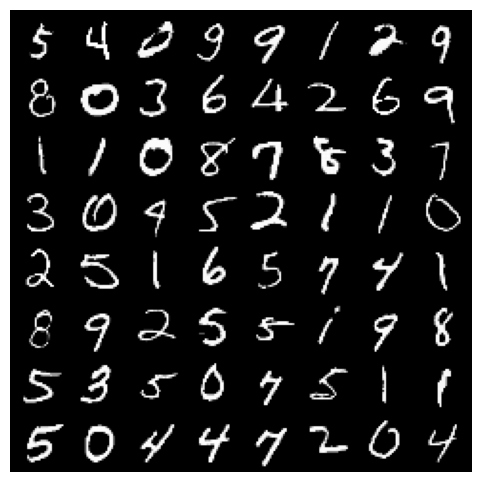

In [7]:
def plot_images(images):
    sample_grid = make_grid(images, nrow=int(np.sqrt(images.shape[0])))
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(sample_grid.cpu().permute(1, 2, 0).squeeze())
    plt.show()

plot_images(x)

In [8]:
def bridge_sample(x_0, x_1, t):
    # x_0 samples from intial dist (baches, chanels, width, height)
    # x_1 samples from final  dist (baches, chanels, width, height)
    t = t.to(device)
    x_0 = x_0.to(device)
    x_1 = x_1.to(device)
    
    t = t[:, None, None, None]
    mu = x_0 * (1-t) + t * x_1
    var = torch.tensor( t * (1-t), device= device )
    z = torch.randn_like(x_1)
    xt = mu + torch.sqrt( var ) * z
    return xt, mu, var

/tmp/ipykernel_114352/3840784560.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor( t * (1-t), device= device )
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 1, 1])


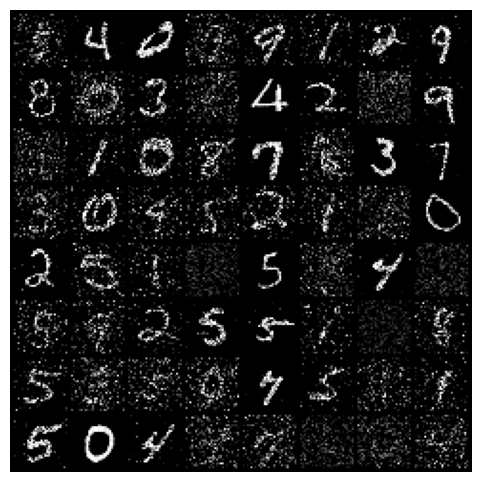

In [9]:
# sampling from the bridge
x_1 = x
x_0 = torch.zeros_like(x_1)
t = torch.rand(x.shape[0], device = device)
xt, mu, var = bridge_sample(x_0, x_1, t)
print(mu.shape)
print(var.shape)
plot_images(xt)



In [10]:
# model takes x, y as input
# x is the data in (B, C, W, H)
# y is the labels
y = model(xt.to(device), None, t)
y.shape

torch.Size([64, 1, 28, 28])

In [11]:
def loss_fn(model, x_0, x_1, eps=1e-5):
    """ Inputs:
          model: score model (i.e. diffusion model)
          x: batch of images
          sde: instance of VP class
          eps: parameter for numerical stability (1e-5 for learning, 1e-3 for sampling)
    """
    t = torch.rand(x_0.shape[0], device=x_0.device) * (1. - eps) + eps  
    z = torch.randn_like(x_0)
    xt, mean, std = bridge_sample(x_0, x_1, t)
    #print(xt.device, t.device)

    # predict the score function for each perturbed x in the batch and its corresponding random t
    score = model(xt, None, t)
    
    # compute loss
    alpha = (xt - mean) / std
    losses = (score - alpha) 
    loss = torch.mean(torch.sum(losses**2 * std**2, dim=(1,2,3)))
    return loss

In [ ]:
from tqdm import trange

lr = 1e-4
n_epochs = 100

checkpoint_path = 'checkpoints/model_checkpoint.pth'
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = []
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    #count = 0
    for x, y in train_loader:
        x_0 = x.to(device)
        x_1 = torch.zeros_like(x).to(device)
        loss = loss_fn(model, x_0, x_1)
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        #print(count, loss.item())
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0] 
        #count += 1
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    losses.append(avg_loss/ num_items)

    # TODO: save model state dictionary at checkpoint_path
    torch.save(model.state_dict(), checkpoint_path)
    # TODO: Experiment with early stopping and patience


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_29429/1385062590.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor( t * (1-t), device= 'cuda' )
Average Loss: 3.729163:  59%|█████▉    | 59/100 [1:33:54<1:05:07, 95.31s/it]

In [ ]:
plt.plot(losses)

In [12]:
# # setup_for_sampling
checkpoint_path = 'checkpoints/model_checkpoint.pth'
model = model.to(device)
model.eval()

model.load_state_dict(torch.load(checkpoint_path, map_location=device))

<All keys matched successfully>

In [13]:
torch.cuda.empty_cache()

In [29]:
T = 1000
batch_size = 64

device = 'cpu'
model.to(device)

x_0 = torch.zeros(batch_size, 1, 28, 28, device=device)
t = torch.ones(x_0.shape[0], device=device) / T
dt = 1 / T

for i in reversed(range(T+1)):
    xt = x_0 + (-x_0 /(1.0 - t[:, None, None, None]+1e-4) - model(x_0, None, i * t + 1e-4) ) * dt + torch.sqrt(torch.tensor(dt)) * torch.randn_like(x_0)
    x_0 = xt.detach()

        
#(x_1 - x_t) / (1.0 - t[:, None, None, None])

In [30]:
xt.shape

torch.Size([64, 1, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


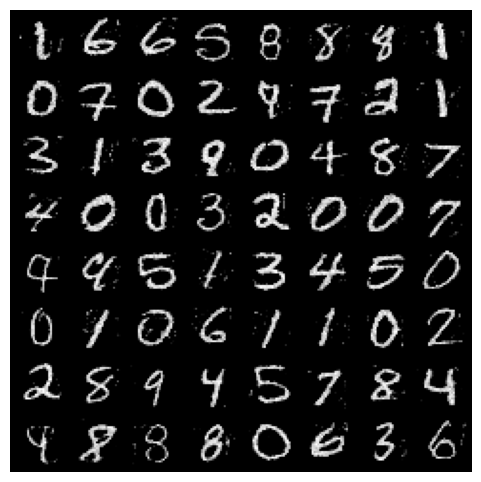

<Figure size 640x480 with 0 Axes>

In [32]:
plot_images(xt)
plt.savefig('generated')